In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tslearn.preprocessing import TimeSeriesResampler
from Process_Functions import Bessel_Filter, Down_sampling, normalized_translocation, interplotation, Draw_Plot, normalized_time_axis, normalized_delta
from scipy.ndimage import gaussian_filter1d
import os


In [2]:
'''
file_name:导入文件的名称 默认为多列时间-电流数据（参考1.xlsx中的格式）
start end 指定导入数据的范围 默认全部
upper lim lower lim 决定数据长度范围

sampling frequency:导入数据的采样频率 默认100(KHz)
cut_off_frequency:截止频率，决定滤波的程度默认2(KHz)
drop head drop_tail 去掉处理后数据的前后几个数据点（由于采用的分离过孔信号方法，前后会产生很高的数据点）默认去掉5个数据点
smooth:是否使用高斯滤波器平滑数据，默认否
normalization_method 决定是-均值/标准差‘standard’还是‘delta’（deltaI/I_0,默认为standard）
'''
def Signal_Processing(file_name,start=None, end=None, upper_lim=None,lower_lim=1,sampling_frequency=100,cut_off_frequency=2,
                      drop_head=5,drop_tail=-5,smooth=False, normalization_method='standard',threshold=60):
    if file_name[-3:]=='lsx':
        original_data=pd.read_excel(file_name)
        
    elif file_name[-3:]=='csv':
        original_data=pd.read_csv(file_name)
    original_data = original_data.filter(regex='^(?!Unnamed)')
    signal_index = [int(col) for n, col in enumerate(original_data.columns) if (n + 1) % 3 == 1]  
    data_cleared=original_data.dropna(axis=1,how='all')
    #slice different serieses
    data_sliced = []
    column_num = len(data_cleared.columns)

    for i in range(0, column_num, 2):
        df_sliced = data_cleared.iloc[:, i:i+2].copy()  
        df_sliced.columns = ['t', 'i' ]
        # 删除所有值为空的行
        new_df_sliced = df_sliced.dropna(axis=0, how="all").copy()
        # 确保 new_df_sliced 不是空的再进行操作
        if not new_df_sliced.empty:
            new_df_sliced.loc[:, new_df_sliced.columns[0]] -= new_df_sliced.iloc[0, 0]
        data_sliced.append(new_df_sliced)

        
    #process the data
    #set parameters
    processed_data=[]
    for series in data_sliced:
        filtered_current=Bessel_Filter(series['i'],sampling_frequency=sampling_frequency,cut_off_frequency=cut_off_frequency)
        filtered_curve=np.array([series['t'],filtered_current])
        down_sampled_curve=filtered_curve
        filtered_curve_dataframe=pd.DataFrame(down_sampled_curve.T,columns=['t','i'])
        if normalization_method=='standard':
            normalized_data=normalized_translocation(filtered_curve_dataframe,threshold=min(filtered_curve_dataframe.iloc[:,1])+threshold,drop_head=drop_head, drop_tail=drop_tail)
            processed_data.append(normalized_data)
        elif normalization_method=='delta':
            normalized_data=normalized_delta(filtered_curve_dataframe,threshold=min(filtered_curve_dataframe.iloc[:,1])+threshold,drop_head=drop_head, drop_tail=drop_tail)
            processed_data.append(normalized_data)

    #select data for further alignment
    if upper_lim is None:
        target_data=processed_data
   
    else:
        target_data=[series for series in processed_data if len(series)<upper_lim and len(series)>lower_lim]
        selected_index=[]
        for index, series in enumerate(processed_data):
            if len(series) < upper_lim and len(series) > lower_lim:
                selected_index.append(index)
        selected_signal_index=[signal_index[i] for i in selected_index]
        
                
    
    #get the length of each selected signal and 
    len_target_data=[len(series) for series in target_data]
    #max_len=max(len_target_data)
    #max_index=[len(series) for series in target_data].index(max_len) 

    #using time_axis normalization method to normallize the time 
    if smooth==True:
        for series in target_data:
            series['i']=gaussian_filter1d(series['i'].values,sigma=3)

    
    time_normalized_data=[normalized_time_axis(series) for series in target_data][start:end]

    
    return time_normalized_data,selected_signal_index

In [3]:

from tslearn.metrics import dtw_path, dtw
from tslearn.preprocessing import TimeSeriesResampler
import seaborn as sns


In [19]:

def dtw_alignment(time_normalized_data,signal_index=None,resample_length=None,plot_series=False,
                  plot_alignment=False,show_matrix=False, series_standard=None,smooth=False,constraint=None,method='classic',sakoe_radius=100,sakoe_ratio=0.3,
                  target_path=None, inverse=False):
    if method=='classic':
        if series_standard is None:
            
            dtw_matrix=np.zeros((len(time_normalized_data),len(time_normalized_data)))

            for i in range(len(time_normalized_data)-1):
                for j in range (i+1, len(time_normalized_data)):
                    series_1=time_normalized_data[i]
                    series_2=time_normalized_data[j]
                    distance=dtw(series_1,series_2)
                    normalized_distance=distance/(len(series_1)+len(series_2))
                    dtw_matrix[i,j]=normalized_distance
                    dtw_matrix[j,i]=normalized_distance
            rows_sums=dtw_matrix.sum(axis=1)
            min_index=np.argmin(rows_sums)
            if signal_index is not None:
                print(signal_index[min_index])
            normalized_dtw_matrix=dtw_matrix/np.amax(dtw_matrix)
            new_mtx = np.where(normalized_dtw_matrix == 0, 1, normalized_dtw_matrix)
            if show_matrix==True:
                sns.heatmap(normalized_dtw_matrix, annot=False, fmt=".2f", cmap="YlGnBu")
                plt.show()
                print(len(rows_sums),min_index)
                min_row,min_col=np.unravel_index(np.argmin(new_mtx),new_mtx.shape)
                print(f'lowest distance is from{(signal_index[min_row],signal_index[min_col])}')
        else:
            pass

        aligned_data=[]
        if series_standard is None:
            series_standard=time_normalized_data[min_index]
            np_series_standard=series_standard.to_numpy()
            np_series_standard_time=np_series_standard[:,0].T
            np_series_standard_current=np_series_standard[:,1].T
        else:
            series_standard=series_standard
            np_series_standard=series_standard.to_numpy()
            np_series_standard_time=np_series_standard[:,0].T
            np_series_standard_current=np_series_standard[:,1].T
            
            
        for i in range(len(time_normalized_data)):
            
            series=time_normalized_data[i]
            standard_series=np_series_standard
            path,_=dtw_path(series,series_standard)
            if constraint is  None:
                path,_=dtw_path(series,series_standard)
                
            elif constraint=="sakoe_chiba":
                if sakoe_radius is None:
                    path,_=dtw_path(series,series_standard,global_constraint=constraint, sakoe_chiba_radius=series.shape[0]*sakoe_ratio)
                else:
                    path,_=dtw_path(series,series_standard,global_constraint=constraint, sakoe_chiba_radius=sakoe_radius)
                
            aligned_series=np.zeros((len(path),2))
            aligned_standard_series=np.zeros((len(path),2))
            for i, (idx1, idx2) in enumerate(path):
                np_series=series.to_numpy()
                aligned_series[i] = np_series[idx1]
                aligned_standard_series[i]=standard_series[idx2]
            #aligned_series_time=[x[0] for x in aligned_series]
            aligned_series_current=[x[1] for x in aligned_series]
            aligned_standard_series_time=[x[0] for x in aligned_standard_series]
            aligned_data.append(np.array([aligned_standard_series_time,aligned_series_current]))
        
        aligned_data_unique=[]
            
        for series in aligned_data:
            unique_series_time,idx=np.unique(series[0,:],return_index=True)
            unique_series_current=series[1,:][idx]
            
            if smooth==True:
                unique_series_current=gaussian_filter1d(unique_series_current,sigma=5)

            if inverse==False:
                aligned_data_unique.append(np.array([unique_series_time,unique_series_current]))
            else:
                aligned_data_unique.append(np.array([unique_series_time,np.flip(unique_series_current)]))  
        

            
        if plot_alignment==True:
            for index, series in enumerate(aligned_data_unique):
                
                if signal_index is None:                   
                        plt.plot(series[0,:], series[1,:],label=str(index))                       
                else:                          
                        plt.plot(series[0,:], series[1,:],label=str(signal_index[index]))

     
                
                if target_path is not None:
                    plt.savefig(os.path.join(target_path,'radius'+str(sakoe_radius)+'.png'))
            if target_path is not None:
                plt.close('all')
            else:
                plt.legend(fontsize=4)
                plt.show()
        len_aligned_data=np.array([series.shape[1] for series in aligned_data_unique])
        max_aligned_len=len_aligned_data.max()
        max_len_index=np.argmax(len_aligned_data)


        resampler=TimeSeriesResampler(sz=max_aligned_len if resample_length is None else resample_length)
        
        interplotation_aligned_data=[resampler.fit_transform(series[-1,:]).ravel() for series in aligned_data_unique]

        average_current=np.sum(interplotation_aligned_data,axis=0)
        average_current/=len(interplotation_aligned_data)
    
            
        return aligned_data_unique, average_current

In [5]:
from tslearn.metrics import gamma_soft_dtw, soft_dtw
from tslearn.barycenters import softdtw_barycenter

import time

In [6]:

def barycenter_plot(data,target_length=500, start=None,end=None,gamma=None,inverse=False, 
                    choose_color='red',plot=False,max_iter=50,tol=1e-3):
    if target_length is None:
        target_length=max([series.shape[0] for series in data])
        resampler=TimeSeriesResampler(sz=target_length)
    else:  
        resampler=TimeSeriesResampler(sz=target_length)
    currents_resampled=[resampler.fit_transform(series).ravel() for series in data[start:end]]
# 调用 softdtw_barycenter 函数计算重心
    if gamma is None:
        gamma_select=[]
        for i in range(5):
            gamma_select.append(gamma_soft_dtw(currents_resampled[:], len(currents_resampled),i ))
        gamma= np.mean(gamma_select)
        print(f'auto_gamma:{gamma:.3f}')
        
    barycenter = softdtw_barycenter(currents_resampled, gamma=gamma,max_iter=max_iter,tol=tol)
    if inverse==True:
        barycenter=np.flip(barycenter)
    else:
        pass
    time=np.linspace(0,1,target_length)
    time_series=[np.array([time,barycenter.ravel()])]   

    return currents_resampled,barycenter,time_series

In [7]:
def comparison_plot(series1=None,series2=None,flip=False,export=False,file_name='',save_path='data export'):
    time_1=np.linspace(0,1, len(series1))  
    time_2=np.linspace(0,1, len(series2))    
    plt.plot(time_1,series1,color='red',label='direction_1')
    
    if flip==True:
        plt.plot(time_2, np.flip(series2),color='blue',label='direction_2')
    else:
        
        plt.plot(time_2,series2,color='blue')
    plt.show()

Import and Process Data

In [5]:
current_dir=os.getcwd()
dir_120='data_120'
dir_final='data_final'
dir_new='data_new'
direction_1='direction_1.xlsx'
direction_2='direction_2.xlsx'

In [6]:
time_normalized_data_1,selected_signal_index_1=Signal_Processing(os.path.join(current_dir,dir_new,direction_1),upper_lim=100000,lower_lim=1,
                                        cut_off_frequency=5,normalization_method='standard',smooth=False,threshold=60)

In [7]:
time_normalized_data_2,selected_signal_index_2=Signal_Processing(os.path.join(current_dir,dir_new,direction_2),upper_lim=2000,lower_lim=100,
                                        cut_off_frequency=5,normalization_method='standard',smooth=False,threshold=60)

In [ ]:
export_data(time_normalized_data_1,save_path=os.path.join('final_export_data','data_alignment'),file_name='direction_1_1',signal_index=selected_signal_index_1)
export_data(time_normalized_data_2,save_path=os.path.join('final_export_data','data_alignment'),file_name='direction_2_2',signal_index=selected_signal_index_2)

In [18]:
print(len(time_normalized_data_1),len(time_normalized_data_2))

77 55


In [16]:
target_numbers_2 =[102, 79, 72, 25,9]
target_numbers_1 = [29, 33, 66, 174]
indices_to_remove_1 = [i for i, num in enumerate(selected_signal_index_1) if num in target_numbers_1]
indices_to_remove_2 = [i for i, num in enumerate(selected_signal_index_2) if num in target_numbers_2]
for index in sorted(indices_to_remove_1, reverse=True):
    del selected_signal_index_1[index]
    del time_normalized_data_1[index]
    
for index in sorted(indices_to_remove_2, reverse=True):
    del selected_signal_index_2[index]
    del time_normalized_data_2[index]


Text(0, 0.5, 'counts')

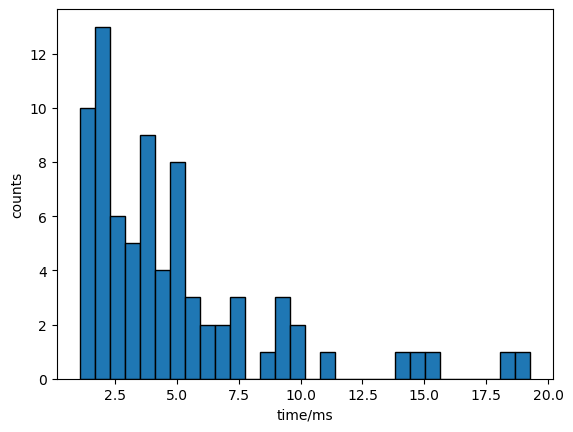

In [19]:
plt.rcParams['figure.dpi'] = 100
plt.hist([series.shape[0]/100 for series in time_normalized_data_1], bins=30,  edgecolor='black')
plt.xlabel('time/ms')
plt.ylabel('counts')

Text(0, 0.5, 'counts')

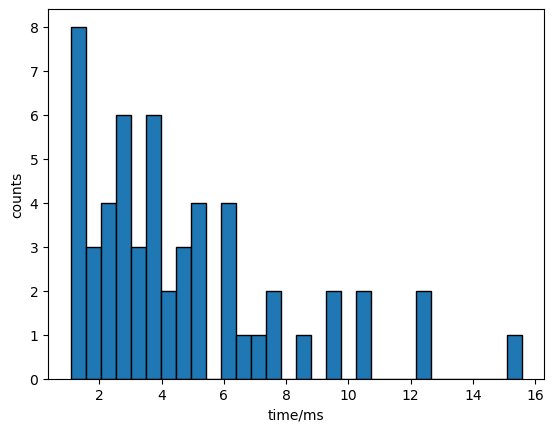

In [20]:
plt.hist([series.shape[0]/100 for series in time_normalized_data_2], bins=30,  edgecolor='black')
plt.xlabel('time/ms')
plt.ylabel('counts')

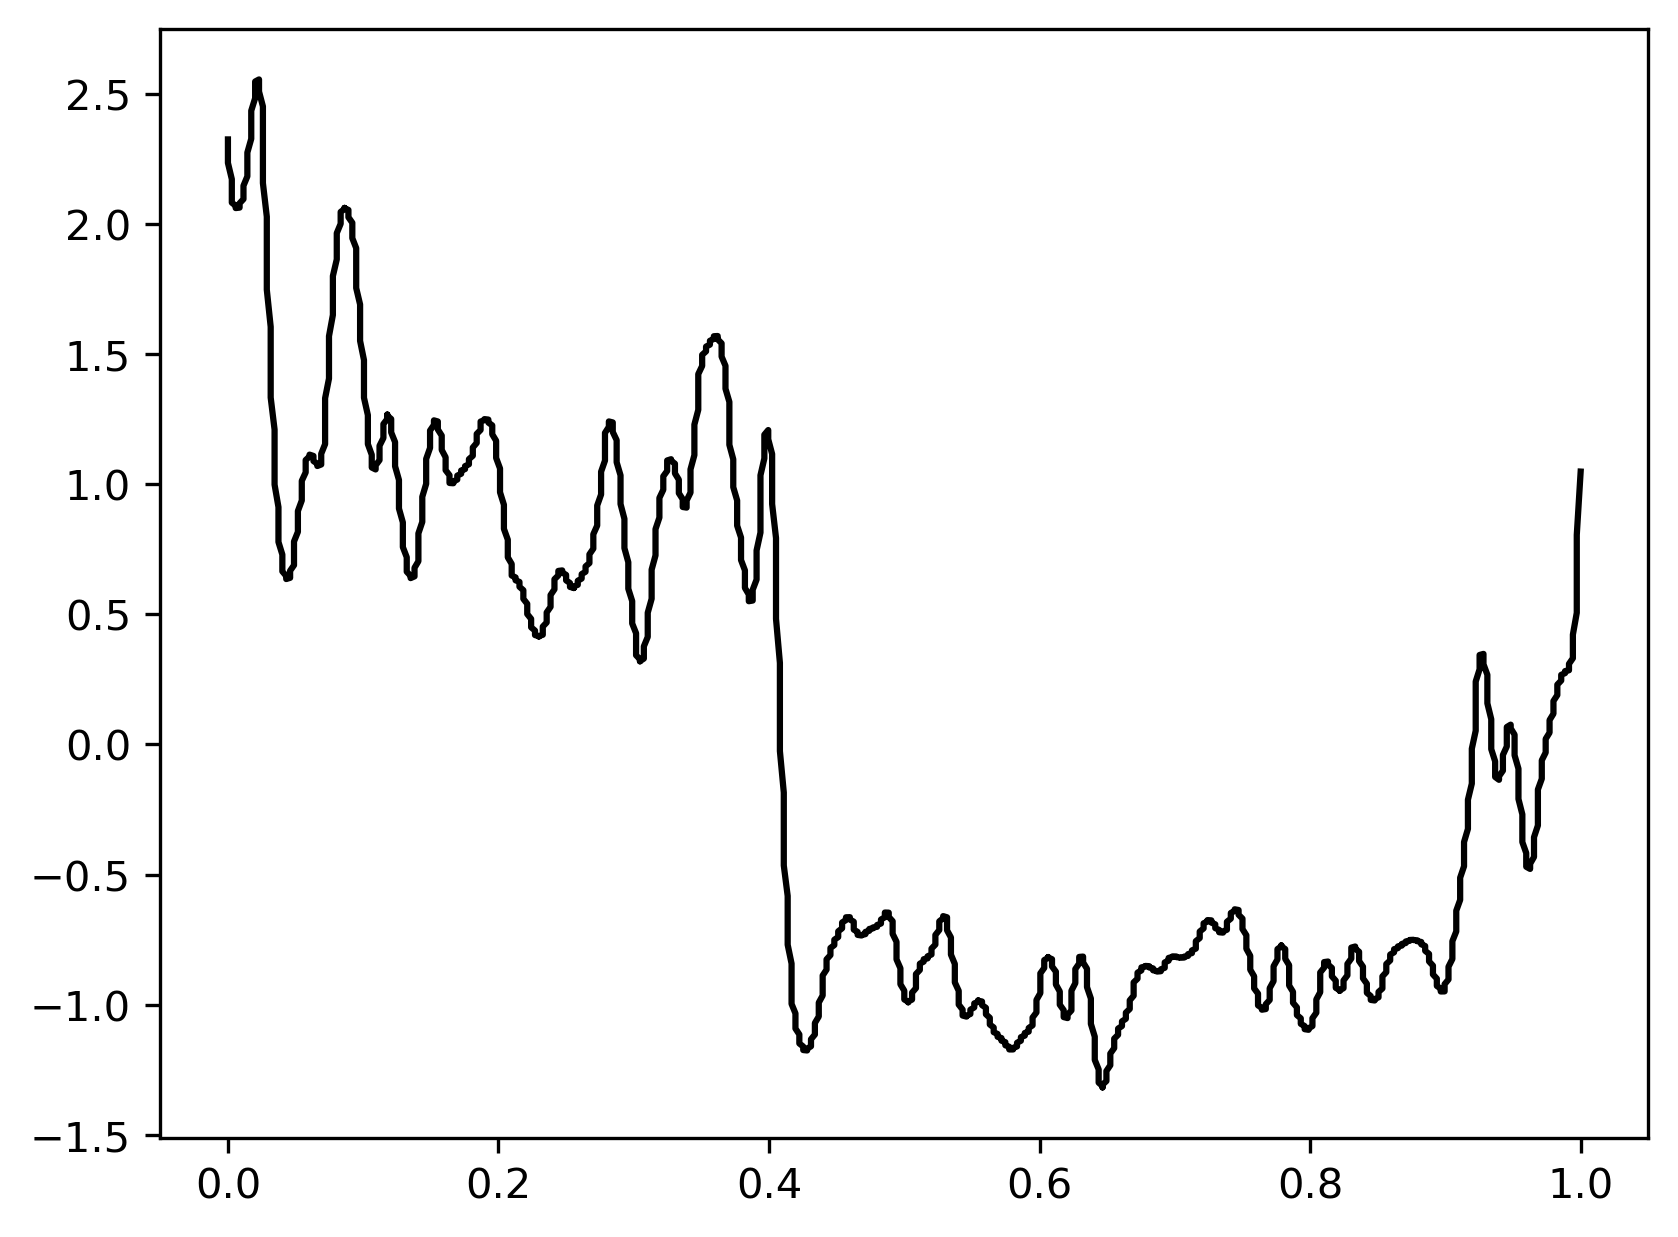

In [14]:
plt.rcParams['figure.dpi'] = 300
plt.plot(time_normalized_data_1[51].iloc[:,0],time_normalized_data_1[51].iloc[:,1],color='black')

145


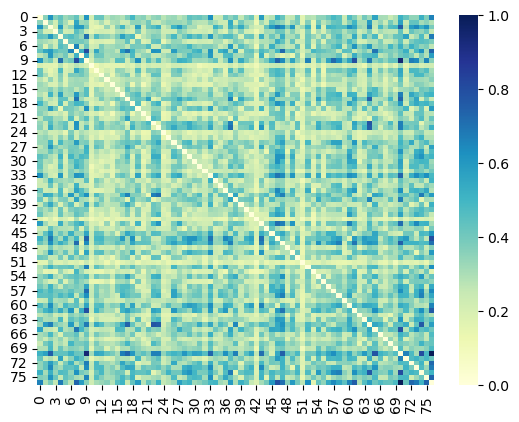

77 51
(145, 180)


In [17]:
aligned_data_unique_1,_=dtw_alignment(time_normalized_data_1,signal_index=selected_signal_index_1,plot_series=True,
                                            plot_alignment=False,show_matrix=True,smooth=False,constraint="sakoe_chiba",
                                            sakoe_radius=None,sakoe_ratio=0.15,target_path=None,inverse=False)

137


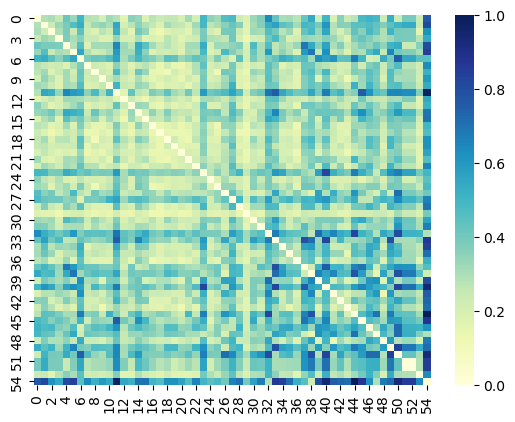

55 29
(42, 100)


In [18]:
aligned_data_unique_2,_=dtw_alignment(time_normalized_data_2,signal_index=selected_signal_index_2,plot_series=True,
                                            plot_alignment=False,show_matrix=True,smooth=False,constraint="sakoe_chiba",
                                            sakoe_radius=100,sakoe_ratio=0.15,target_path=None,inverse=False)

Draw the Plot

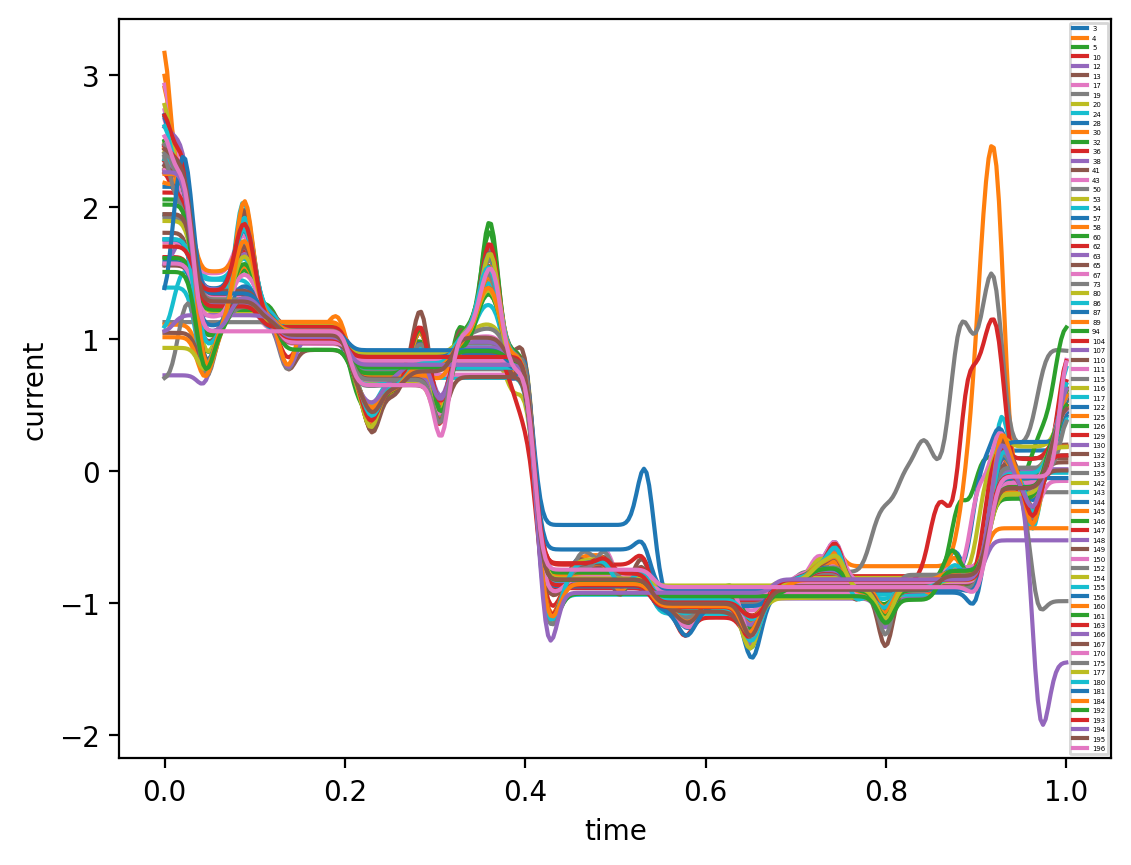

In [50]:
plt.rcParams['figure.dpi'] = 200
for index, series in enumerate(aligned_data_unique_1):
            
    plt.plot(series[0,:], gaussian_filter1d(series[1,:],sigma=2.5) ,label=str(selected_signal_index_1[index]))

plt.legend(fontsize=2.5)
plt.xlabel('time')
plt.ylabel('current')
plt.show()

In [ ]:
from cycler import cycler
plt.rcParams['figure.dpi'] = 100
num=9
num_groups = len(aligned_data_unique_1) // num

for group_idx in range(num_groups):
    start = group_idx * num
    end = (group_idx + 1) * num
    group_data = aligned_data_unique_1[start:end]
    group_index = selected_signal_index_1[start:end]
    

    for index, series in enumerate(group_data):
        x = series[0, :]
        y = gaussian_filter1d(series[1, :], sigma=2.5)

        plt.plot(x, y, label=str(group_index[index]))
    plt.legend(fontsize=6)
    plt.show()

# 处理剩余不足 15 个的数据
remaining_start = num_groups * 15
remaining_data = aligned_data_unique_1[remaining_start:]
remaining_index = selected_signal_index_1[remaining_start:]
if remaining_data:
    for index, series in enumerate(remaining_data):
        x = series[0, :]
        y = gaussian_filter1d(series[1, :], sigma=2.5)
        plt.plot(x, y, label=str(group_index[index]))

plt.legend(fontsize=3)
plt.show()

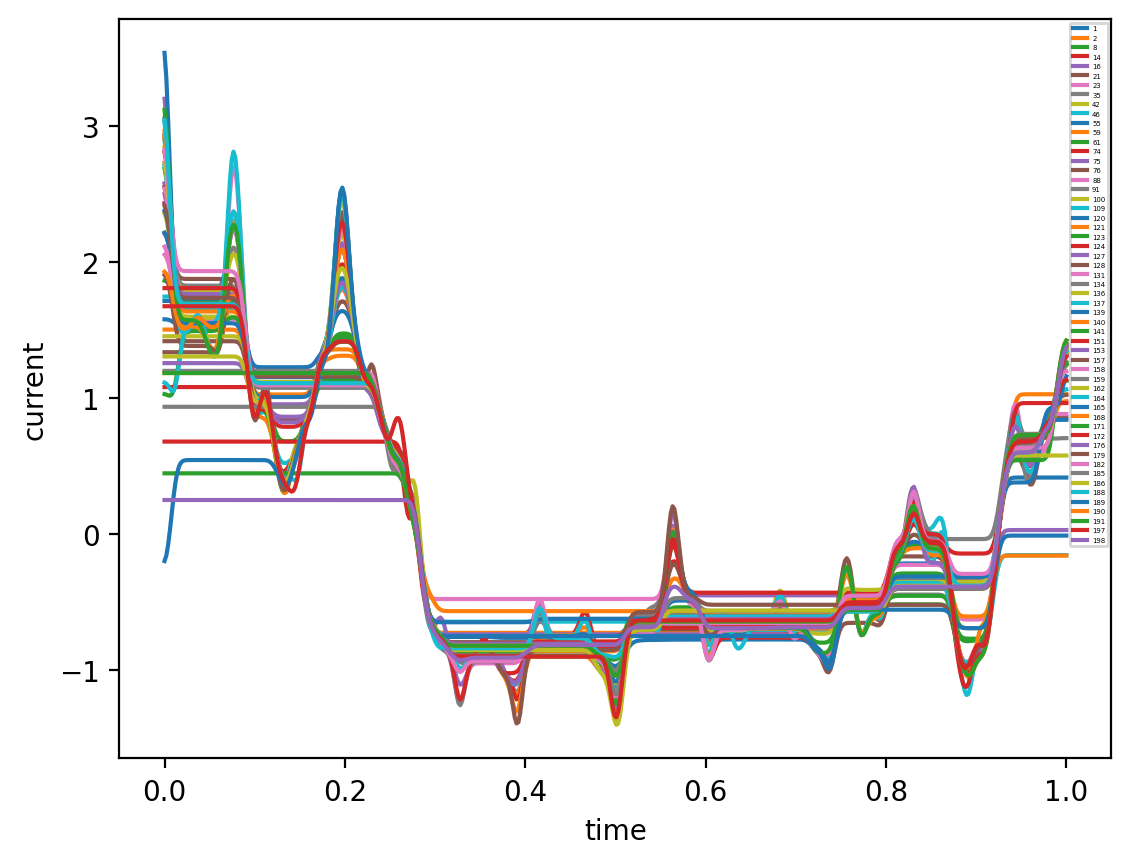

In [51]:
plt.rcParams['figure.dpi'] = 200
for index, series in enumerate(aligned_data_unique_2):
            
    plt.plot(series[0,:], gaussian_filter1d(series[1,:],sigma=2.5) ,label=str(selected_signal_index_2[index]))

plt.legend(fontsize=2.5)
plt.xlabel('time')
plt.ylabel('current')
plt.show()

In [ ]:
plt.rcParams['figure.dpi'] = 100
num=9
num_groups = len(aligned_data_unique_2) // num
for group_idx in range(num_groups):
    start = group_idx * num
    end = (group_idx + 1) * num
    group_data = aligned_data_unique_2[start:end]
    group_index = selected_signal_index_2[start:end]

    for index, series in enumerate(group_data):
        x = series[0, :]
        y = gaussian_filter1d(series[1, :], sigma=2.5)

        plt.plot(x, y, label=str(group_index[index]))
    plt.legend(fontsize=6)
    plt.show()

# 处理剩余不足 15 个的数据
remaining_start = num_groups * 15
remaining_data = aligned_data_unique_2[remaining_start:]
remaining_index = selected_signal_index_2[remaining_start:]
if remaining_data:
    for index, series in enumerate(remaining_data):
        x = series[0, :]
        y = gaussian_filter1d(series[1, :], sigma=2.5)
        plt.plot(x, y, label=str(group_index[index]))

plt.legend(fontsize=3)
plt.show()

Export alignment

In [25]:
def export_data(data,save_path='',file_name='1',signal_index=None):
    data_processed=[]
    if signal_index==None:
        for i in range(len(data)):
            series_index=pd.DataFrame([], columns=[str(i+1)])
            data_processed.append(series_index)
            if isinstance(data[0],np.ndarray):
                print(data[0].ndim==1)
                if data[0].ndim==1:
                    data_processed.append(pd.DataFrame({'t':np.linspace(0,1,len(data[i])),'i':data[i]}))
                elif data[0].ndim==2:
                    data_processed.append(pd.DataFrame(data[i].T,columns=['t','i']))
                else:
                    print('TypeError, Please check data type')
            elif isinstance(data[0],pd.DataFrame):
                data_processed.append(data[i])
            else:
                print('TypeError, Please check data type')
            
    else:
        for i,ind in enumerate(signal_index):
            series_index=pd.DataFrame([], columns=[str(ind)])
            data_processed.append(series_index)
            
            if isinstance(data[0],np.ndarray):
                if data[0].ndim==1:
                    data_processed.append(pd.DataFrame({'t':np.linspace(0,1,len(data[i])),'i':data[i]}))
                elif data[0].ndim==2:
                    data_processed.append(pd.DataFrame(data[i].T,columns=['t','i']))
                else:
                    print('TypeError, Please check data type')
            elif isinstance(data[0],pd.DataFrame):
                data_processed.append(data[i])
            else:
                    print('TypeError, Please check data type')

            
            
    
#merge all the data 
    max_length = max([df.shape[0] for df in data_processed])

    # 填充每个 DataFrame 至最大行数
    for i, df in enumerate(data_processed):
        if df.shape[0] < max_length:
            num_missing = max_length - df.shape[0]
            missing_df = pd.DataFrame(index=range(num_missing), columns=df.columns)
            data_processed[i] = pd.concat([df, missing_df], ignore_index=True)

    # 水平拼接所有 DataFrame
    combined_df = pd.concat(data_processed, axis=1)

    # 导出为 Excel 文件
    cur_dir=os.getcwd()
    abs_save_path=os.path.join(cur_dir,save_path)
    if not os.path.exists(abs_save_path):
        os.makedirs(abs_save_path)
    combined_df.to_excel(os.path.join(abs_save_path,file_name+'.xlsx'), index=False)

In [56]:
import copy
def filter_arr(data):
    data_1=[]
    

    
    for arr in data:
        arr_1=copy.deepcopy(arr)
        arr_1[1,:]=gaussian_filter1d(arr[1,:],sigma=2.5)
        data_1.append(arr_1)
    return data_1
aligned_data_1_filtered=filter_arr(aligned_data_unique_1)
aligned_data_2_filtered=filter_arr(aligned_data_unique_2)

In [57]:
export_data(aligned_data_1_filtered,save_path=os.path.join('final_export_data','data_alignment'),file_name='direction_1_1',signal_index=selected_signal_index_1)
export_data(aligned_data_2_filtered,save_path=os.path.join('final_export_data','data_alignment'),file_name='direction_2_2',signal_index=selected_signal_index_2)

Barycenter Plot

In [26]:
def barycenter_process(data,target_length=500):
    data_current=[series.to_numpy().T[1,:] for series in data]
    _,barycenter,time_series=barycenter_plot([gaussian_filter1d(series,sigma=5) for series in data_current],target_length=target_length,
                                                                    gamma=0.5,max_iter=500)
    data_time=np.linspace(0,1,len(barycenter))
    data_standard_series=pd.DataFrame({'t':data_time,'i':barycenter.ravel()})
    _,average_signal=dtw_alignment(data,series_standard= data_standard_series)
    return average_signal

    

In [27]:
average_signal_1=barycenter_process(time_normalized_data_1,target_length=500)

In [28]:
average_signal_2=barycenter_process(time_normalized_data_2)

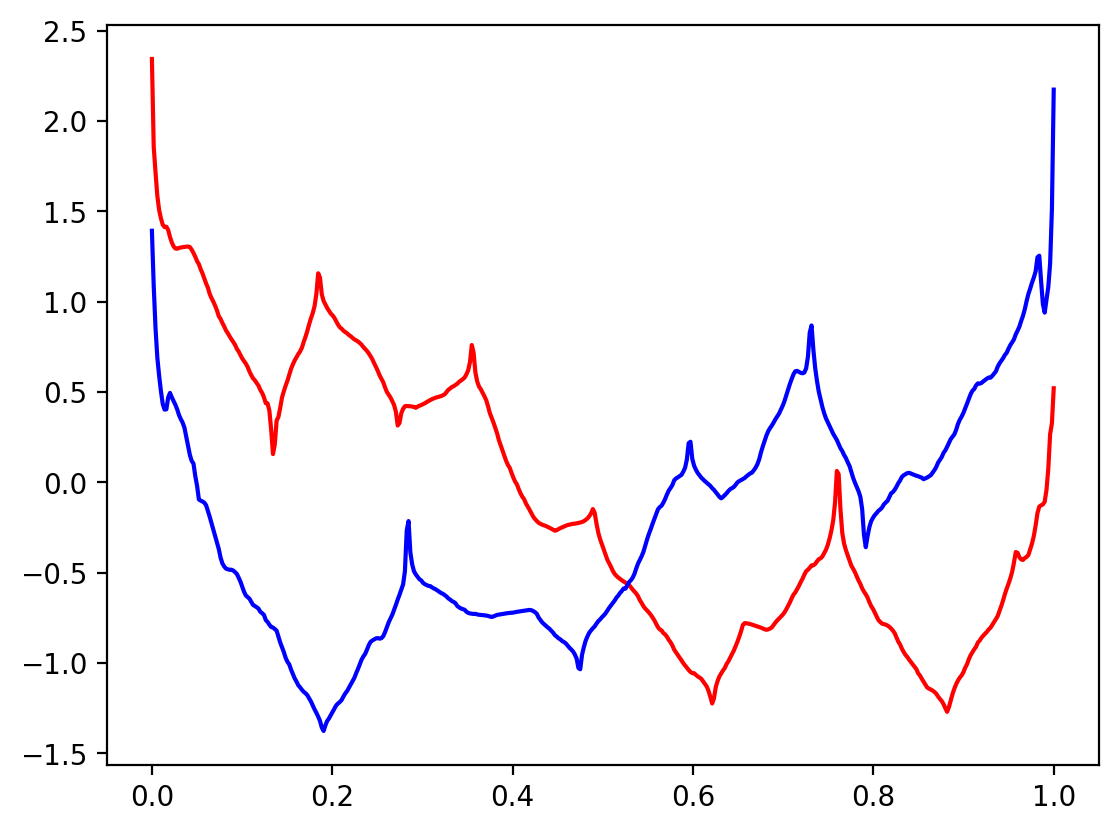

In [32]:
comparison_plot(series1=gaussian_filter1d(average_signal_1,sigma=0.5) ,series2=gaussian_filter1d(average_signal_2,sigma=0.5),flip=True)

In [33]:
average_signal_1_export=gaussian_filter1d(average_signal_1,sigma=2.5)
average_signal_2_export=np.flip(gaussian_filter1d(average_signal_2,sigma=2.5))
average_signal=[average_signal_1_export,average_signal_2_export]
export_data(average_signal,save_path=os.path.join('final_export_data','total_barycenter'),file_name='total_barycenter')



True
True


DTW barycenter Random test

In [33]:
import random
import math 
def random_grouping(lst, group_num=3, seed_value=42):
    group_size=math.ceil(len(lst)/group_num)
    indexed_lst = [(i, value) for i, value in enumerate(lst)]
    random.seed(seed_value)
    random.shuffle(indexed_lst)
    groups = []
    original_indices_groups = []
    for i in range(0, len(indexed_lst), group_size):
        group = indexed_lst[i:i + group_size]
        original_indices = [index for index, _ in group]
        values = [value for _, value in group]
        groups.append(values)
        original_indices_groups.append(original_indices)
    return groups, original_indices_groups

In [36]:
from tslearn.preprocessing import TimeSeriesResampler
def average_current(data,resample_length=None):   
    max_aligned_len=max([series.shape[1] for series in data])
    resampler=TimeSeriesResampler(sz=max_aligned_len if resample_length is None else resample_length)
    
    interplotation_aligned_data=[resampler.fit_transform(series[-1,:]).ravel() for series in data]

    average_current=np.sum(interplotation_aligned_data,axis=0)
    average_current/=len(interplotation_aligned_data)
    
        
    return average_current

In [ ]:
for seed in (7,14,20,23,27,35,36,37,41,48):
    direction_2_groups,direction_2_index=random_grouping(time_normalized_data_2,group_num=3,seed_value=seed)
    direction_2_original_index = [[selected_signal_index_2[i] for i in series] for series in direction_2_index]
    barycenter_series_2=[]
    barycenter_series_export=[]
    for series in direction_2_groups:
        series=barycenter_process(series)    
        barycenter_series_2.append(series)
        barycenter_series_export.append(gaussian_filter1d(series,sigma=2.5).ravel())
    barycenter_series_export.append(average_signal_2_export.ravel())
    export_data(barycenter_series_export,save_path=os.path.join('final_export_data','random_group_barycenter','direction_2'),file_name='direction_2'+'seed'+str(seed))
    soft_dtw_series_2=[]
    for series in barycenter_series_2:
        series_time=np.linspace(0,1,len(series))
        soft_dtw_series_2.append(pd.DataFrame({'t':series_time,'i':series}))
    aligned_barycenter_2,_=dtw_alignment(soft_dtw_series_2,signal_index=None,plot_series=True,
                                        plot_alignment=False,show_matrix=False,smooth=False,constraint="sakoe_chiba",
                                        sakoe_radius=80,target_path=None,inverse=False,series_standard=None)
    
    aligned_barycenter_export=[gaussian_filter1d(series[-1,:],sigma=2.5).ravel() for series in aligned_barycenter_2 ]
    aligned_barycenter_export.append(average_signal_2_export.ravel())
    export_data(aligned_barycenter_export,save_path=os.path.join('final_export_data','random_group_barycenter_aligned','direction_2'),file_name='direction_2'+'seed'+str(seed))
    average_current_2 = gaussian_filter1d(average_current(aligned_barycenter_2, resample_length=500),sigma=2.5).ravel()
    av_lst=[average_current_2]
    av_lst.append(average_signal_2_export.ravel())
    export_data(av_lst,save_path=os.path.join('final_export_data','random_group_barycenter_average','direction_2'),file_name='direction_2'+'seed'+str(seed))
    
 

In [39]:
direction_2_groups,direction_2_index=random_grouping(time_normalized_data_2,group_num=3,seed_value=1)

In [ ]:
barycenter_series_2=[]
for series in direction_2_groups:    
    barycenter_series_2.append(barycenter_process(series))

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mse_2=[]
for group, series in enumerate(barycenter_series_2[:]):
    mse=mean_squared_error(average_signal_2,series)
    mse_2.append(round(mse,ndigits=4))

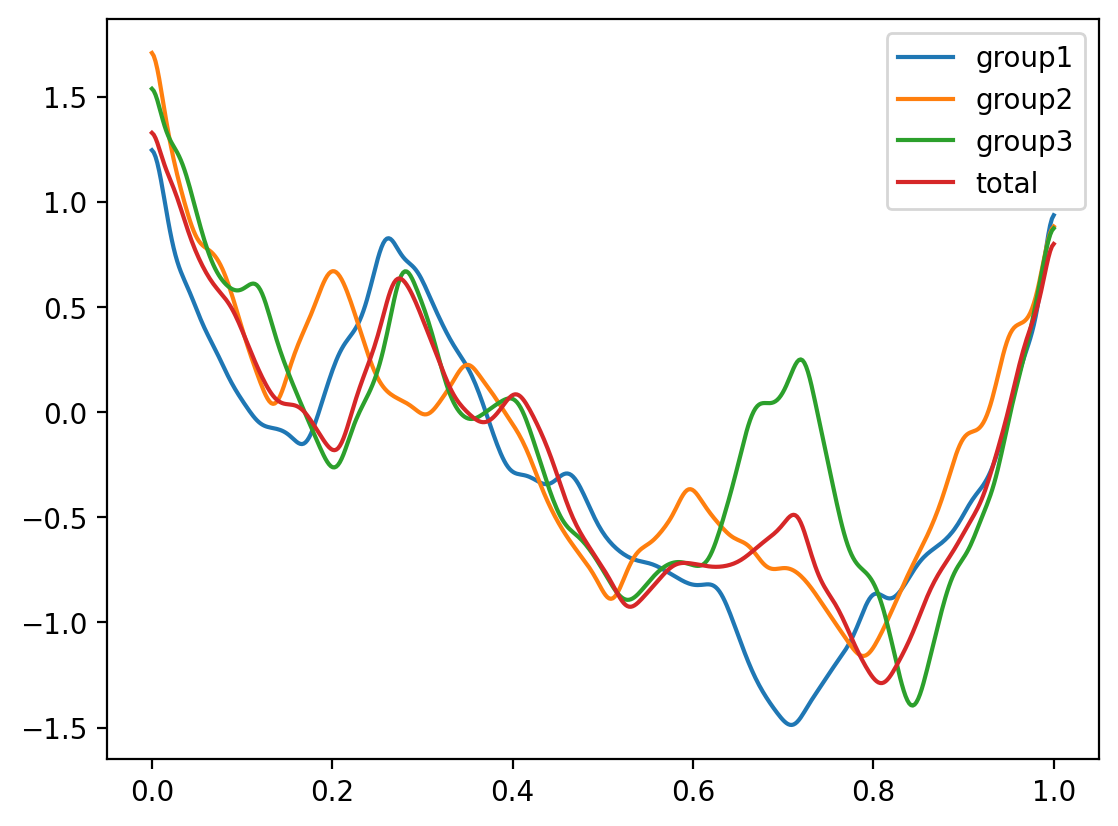

In [42]:
for group, series in enumerate(barycenter_series_2[:]):
    series_time=np.linspace(0,1,len(series))
    plt.plot(series_time,gaussian_filter1d(series,sigma=5),label='group'+str(group+1))
plt.plot(np.linspace(0,1,len(average_signal_2)),gaussian_filter1d(average_signal_2,sigma=5),label='total')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mse_2_total=[]
mse_2_alignment=[]
cur_dir=os.getcwd()
target_path=os.path.join(cur_dir,'figure_final','test_figure','direction_2')
align_path=os.path.join(cur_dir,'figure_final','alignment_figure','direction_2')
for  i in range(1,50):
    direction_2_groups,direction_2_index=random_grouping(time_normalized_data_2,group_num=3,seed_value=i)
    direction_2_original_index = [[selected_signal_index_2[i] for i in series] for series in direction_2_index]
    barycenter_series_2=[]
    mse_2=[]
    for series in direction_2_groups:    
        barycenter_series_2.append(barycenter_process(series))


    
    for group, series in enumerate(barycenter_series_2[:]):
        mse=mean_squared_error(average_signal_2,series)
        mse_2.append(round(mse,ndigits=4))
    
        
        series_time=np.linspace(0,1,len(series))
        plt.plot(series_time,gaussian_filter1d(series,sigma=2.5),label='group'+str(group+1)+'mse'+str(mse_2[group]))
    mean_mse_2=sum(mse_2)/len(mse_2)
    mse_2_total.append(mse_2)
    plt.plot(np.linspace(0,1,len(average_signal_2)),gaussian_filter1d(average_signal_2,sigma=2.5),label='total')
    plt.title('direction_'+'seed'+str(i)+'mse_mean'+str(mean_mse_2))
    plt.legend()
    plt.savefig(os.path.join(target_path,'direction_2'+'seed'+str(i)))
    plt.clf()


    soft_dtw_series_2=[]
    for series in barycenter_series_2:
        series_time=np.linspace(0,1,len(series))
        soft_dtw_series_2.append(pd.DataFrame({'t':series_time,'i':series}))
    aligned_barycenter_2,_=dtw_alignment(soft_dtw_series_2,signal_index=None,plot_series=True,
                                        plot_alignment=False,show_matrix=False,smooth=False,constraint="sakoe_chiba",
                                        sakoe_radius=80,target_path=None,inverse=False,series_standard=None)

    mse2=[]   
    for index, series in enumerate(aligned_barycenter_2):
        mse=mean_squared_error(average_signal_2,series[1,:])
        mse2.append(round(mse,ndigits=4))
        mean_mse_2=sum(mse2)/len(mse2)
        mse_2_alignment.append(mse2)


            
        plt.plot(series[0,:], gaussian_filter1d(series[1,:],sigma=2.5),label='group'+str(index+1)+'mse'+str(mse2[index]))

    plt.plot(np.linspace(0,1,len(average_signal_2)),gaussian_filter1d(average_signal_2,sigma=2.5),label='total')

    plt.legend(fontsize=10)
    plt.savefig(os.path.join(align_path,'direction_2'+'seed'+str(i)+'mse'+str(round(mean_mse_2,ndigits=4))+'.png'))
    plt.clf()



plt.close('all')




In [45]:
soft_dtw_series_2=[]
for series in barycenter_series_2:
    series_time=np.linspace(0,1,len(series))
    soft_dtw_series_2.append(pd.DataFrame({'t':series_time,'i':series}))


DTW aligment for the three barycenter plot

In [46]:
aligned_barycenter_2,_=dtw_alignment(soft_dtw_series_2,signal_index=None,plot_series=True,
                                            plot_alignment=False,show_matrix=False,smooth=False,constraint="sakoe_chiba",
                                            sakoe_radius=80,target_path=None,inverse=False)

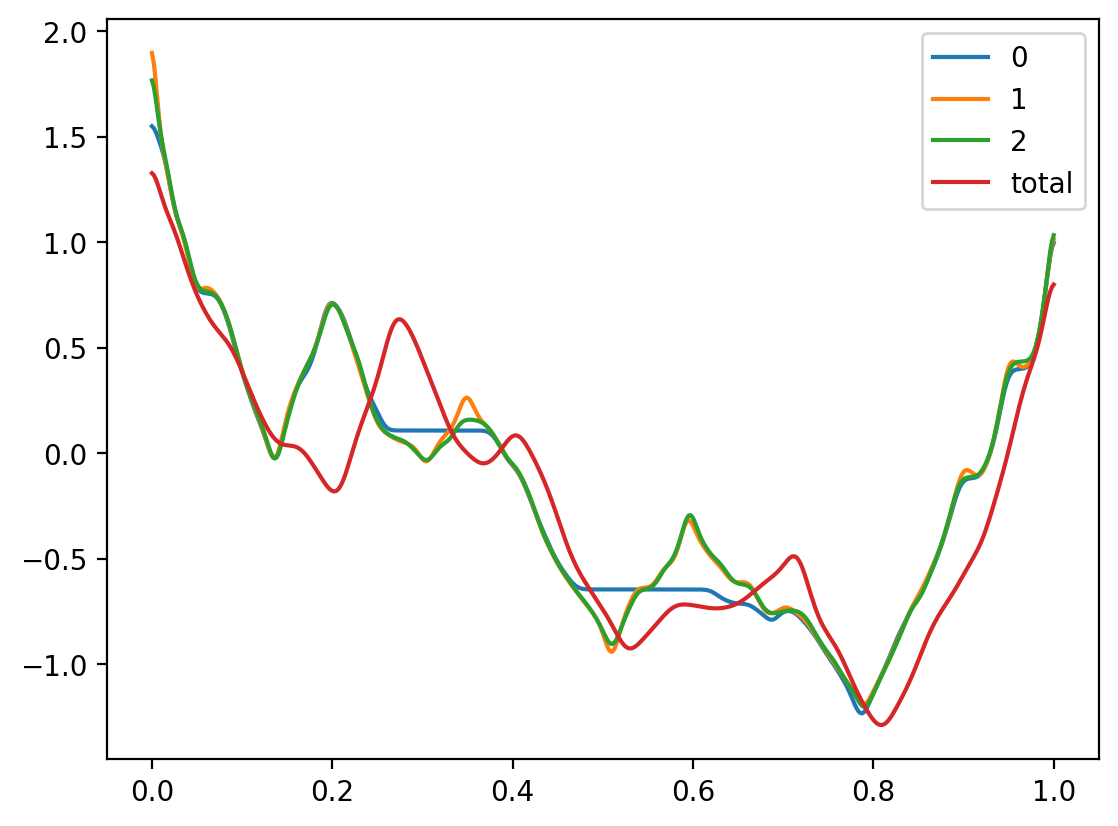

In [47]:
for index, series in enumerate(aligned_barycenter_2):
            
    plt.plot(series[0,:], gaussian_filter1d(series[1,:],sigma=3),label=str(index))

plt.plot(np.linspace(0,1,len(average_signal_2)),gaussian_filter1d(average_signal_2,sigma=5),label='total')
plt.legend(fontsize=10)
plt.show()

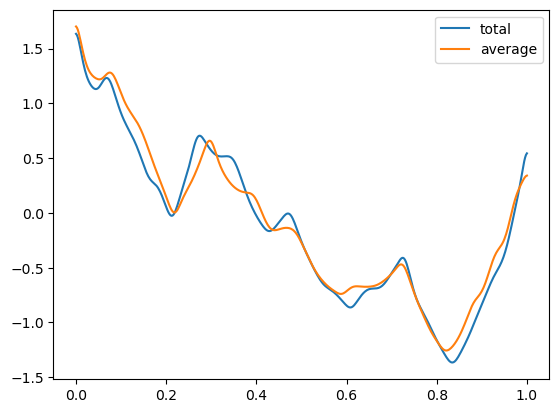

In [ ]:
average_current_2=average_current(aligned_barycenter_2,resample_length=500)
plt.plot(np.linspace(0,1,len(average_signal_2)),gaussian_filter1d(average_signal_2,sigma=5),label='total')
plt.plot(np.linspace(0,1,len(average_current_2)),gaussian_filter1d(average_current_2,sigma=5),label='average')
plt.legend(fontsize=10)
plt.show()

Direction_1_Test

In [ ]:
direction_1_groups,direction_1_index=random_grouping(time_normalized_data_1,seed_value=1)
direction_1_original_index = [[selected_signal_index_1[i] for i in series]  for series in direction_1_index]

In [ ]:
barycenter_series_1=[]
for series in direction_1_groups:    
    barycenter_series_1.append(barycenter_process(series))

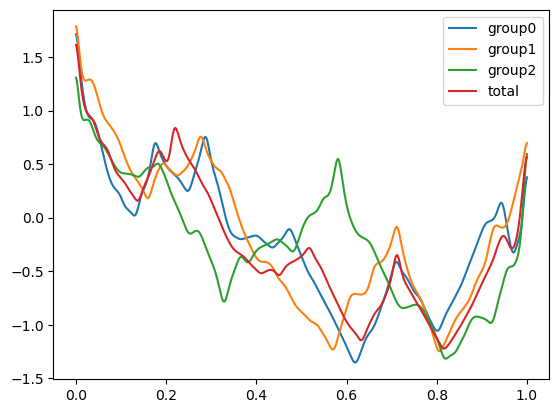

In [ ]:
for group, series in enumerate(barycenter_series_1[:]):
    series_time=np.linspace(0,1,len(series))
    plt.plot(series_time,gaussian_filter1d(series,sigma=3),label='group'+str(group))
plt.plot(np.linspace(0,1,len(average_signal_1)),gaussian_filter1d(average_signal_1,sigma=3),label='total')
plt.legend()
plt.show()

In [ ]:
soft_dtw_series_1=[]
for series in barycenter_series_1:
    series_time=np.linspace(0,1,len(series))
    soft_dtw_series_1.append(pd.DataFrame({'t':series_time,'i':series}))

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
cur_dir=os.getcwd()
target_path=os.path.join(cur_dir,'figure_final','test_figure','direction_1')
align_path=os.path.join(cur_dir,'figure_final','alignment_figure','direction_1')
mse_1_total=[]
mse_1_alignment=[]
for  i in range(1,50):
    direction_1_groups,direction_1_index=random_grouping(time_normalized_data_1,group_num=3,seed_value=i)
    direction_1_original_index = [[selected_signal_index_1[i] for i in series] for series in direction_1_index]
    barycenter_series_1=[]

    mse_1=[]
    for series in direction_1_groups:    
        barycenter_series_1.append(barycenter_process(series))


    for group, series in enumerate(barycenter_series_1[:]):
        mse=mean_squared_error(average_signal_1,series)
        mse_1.append(round(mse,ndigits=4))
        series_time=np.linspace(0,1,len(series))
        plt.plot(series_time,gaussian_filter1d(series,sigma=2.5),label='group'+str(group+1)+'mse'+str(mse_1[group]))
    mean_mse_1=sum(mse_1)/len(mse_1)
    mse_1_total.append(mse_1)
    plt.plot(np.linspace(0,1,len(average_signal_1)),gaussian_filter1d(average_signal_1,sigma=2.5),label='total')
    plt.title('direction_1'+'seed'+str(i)+'mse'+str(mean_mse_1))
    plt.legend()
    plt.savefig(os.path.join(target_path,'direction_1'+'seed'+str(i)))
    plt.clf()


    soft_dtw_series_1=[]
    for series in barycenter_series_1:
        series_time=np.linspace(0,1,len(series))
        soft_dtw_series_1.append(pd.DataFrame({'t':series_time,'i':series}))
    aligned_barycenter_1,_=dtw_alignment(soft_dtw_series_1,signal_index=None,plot_series=True,
                                            plot_alignment=False,show_matrix=False,smooth=False,constraint="sakoe_chiba",
                                            sakoe_radius=80,target_path=None,inverse=False,series_standard=None)

    mse1=[]   
    for index, series in enumerate(aligned_barycenter_1):
        mse=mean_squared_error(average_signal_1,series[1,:])
        mse1.append(round(mse,ndigits=4))


                
        plt.plot(series[0,:], gaussian_filter1d(series[1,:],sigma=2.5),label='group'+str(index+1)+'mse'+str(mse1[index]))
    mean_mse_1=sum(mse1)/len(mse1)
    mse_1_alignment.append(mse1)

    plt.plot(np.linspace(0,1,len(average_signal_1)),gaussian_filter1d(average_signal_1,sigma=2.5),label='total')

    plt.legend(fontsize=10)
    plt.savefig(os.path.join(align_path,'direction_1'+'seed'+str(i)+'mse'+str(round(mean_mse_2,ndigits=4))+'.png'))
    plt.clf()

    plt.close('all')





In [ ]:
np.argmin(np.array([np.array(x).mean() for x in mse_2_total]))

35

In [36]:
for seed in (1,2,3,13,15,21,29,30,36,48):
    direction_1_groups, direction_1_index = random_grouping(time_normalized_data_1, group_num=3, seed_value=seed)
    direction_1_original_index = [[selected_signal_index_1[i] for i in series] for series in direction_1_index]
    barycenter_series_1 = []
    barycenter_series_export = []
    for series in direction_1_groups:
        series = barycenter_process(series)
        barycenter_series_1.append(series)
        barycenter_series_export.append(gaussian_filter1d(series, sigma=2.5).ravel())
    barycenter_series_export.append(average_signal_1_export.ravel())
    export_data(barycenter_series_export, save_path=os.path.join('final_export_data', 'random_group_barycenter', 'direction_1'), file_name='direction_1' + 'seed' + str(seed))
    soft_dtw_series_1 = []
    for series in barycenter_series_1:
        series_time = np.linspace(0, 1, len(series))
        soft_dtw_series_1.append(pd.DataFrame({'t': series_time, 'i': series}))
    aligned_barycenter_1, _ = dtw_alignment(soft_dtw_series_1, signal_index=None, plot_series=True,
                                            plot_alignment=False, show_matrix=False, smooth=False, constraint="sakoe_chiba",
                                            sakoe_radius=80, target_path=None, inverse=False, series_standard=None)
    aligned_barycenter_export = [gaussian_filter1d(series[-1, :], sigma=2.5).ravel() for series in aligned_barycenter_1]
    aligned_barycenter_export.append(average_signal_1_export.ravel())
    export_data(aligned_barycenter_export, save_path=os.path.join('final_export_data', 'random_group_barycenter_aligned', 'direction_1'), file_name='direction_1' + 'seed' + str(seed))
    average_current_1 = gaussian_filter1d(average_current(aligned_barycenter_1, resample_length=500), sigma=2.5).ravel()
    av_lst = [average_current_1]
    av_lst.append(average_signal_1_export.ravel())
    export_data(av_lst, save_path=os.path.join('final_export_data', 'random_group_barycenter_average', 'direction_1'), file_name='direction_1' + 'seed' + str(seed))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
aligned_barycenter_1,_=dtw_alignment(soft_dtw_series_1,signal_index=None,plot_series=True,
                                            plot_alignment=False,show_matrix=False,smooth=False,constraint="sakoe_chiba",
                                            sakoe_radius=80,target_path=None,inverse=False)

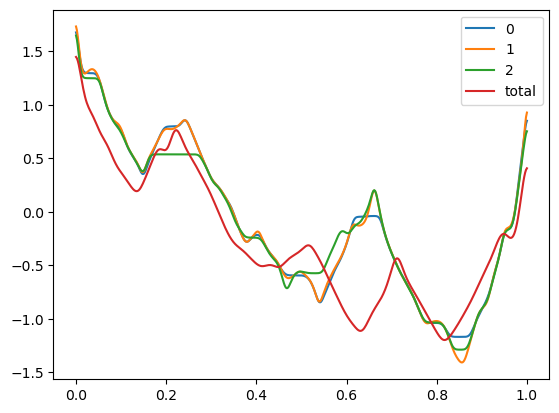

In [ ]:
for index, series in enumerate(aligned_barycenter_1):
            
    plt.plot(series[0,:], gaussian_filter1d(series[1,:],sigma=3),label=str(index))

plt.plot(np.linspace(0,1,len(average_signal_1)),gaussian_filter1d(average_signal_1,sigma=5),label='total')
plt.legend(fontsize=10)
plt.show()

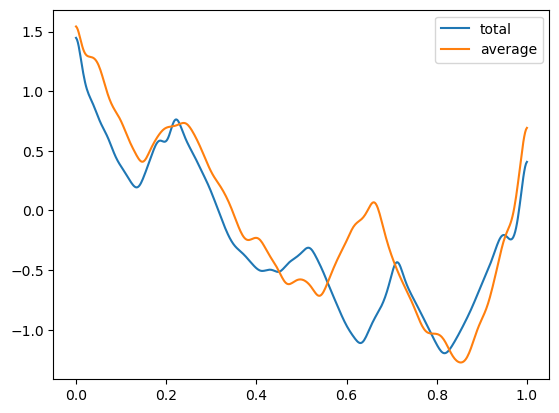

In [ ]:
average_current_1 = average_current(aligned_barycenter_1, resample_length=500)
plt.plot(np.linspace(0, 1, len(average_signal_1)), gaussian_filter1d(average_signal_1, sigma=5), label='total')
plt.plot(np.linspace(0, 1, len(average_current_1)), gaussian_filter1d(average_current_1, sigma=5), label='average')
plt.legend(fontsize=10)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mse_1=[]
for index, series in enumerate(aligned_barycenter_1):
    mse=mean_absolute_error(average_signal_1,series[1,:])
    mse_1.append(mse)
print(mse_1)

[0.27388492759858013, 0.2882793713321474, 0.2769549614273397]


In [ ]:
mse_2=[]
for index, series in enumerate(aligned_barycenter_2):
    mse=mean_absolute_error(average_signal_2,series[1,:])
    mse_2.append(mse)
print(mse_2)

[0.11145084150850684, 0.11653720739540449, 0.11186026350937872]


DTW alignment random test

In [ ]:
aligned_data_set_2=[]
for group, series in enumerate(direction_2_groups):
    aligned_data_group,_=dtw_alignment(series,signal_index=direction_2_original_index[group],plot_series=True,
                                            plot_alignment=False,show_matrix=False,smooth=False,constraint="sakoe_chiba",
                                            sakoe_radius=100,target_path=None,inverse=False,series_standard=soft_dtw_series[group])
    aligned_data_set_2.append(aligned_data_group)
    

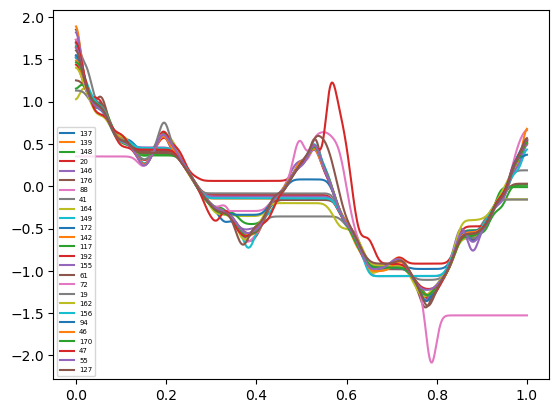

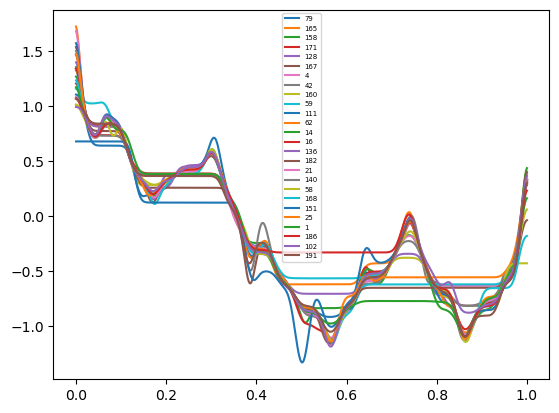

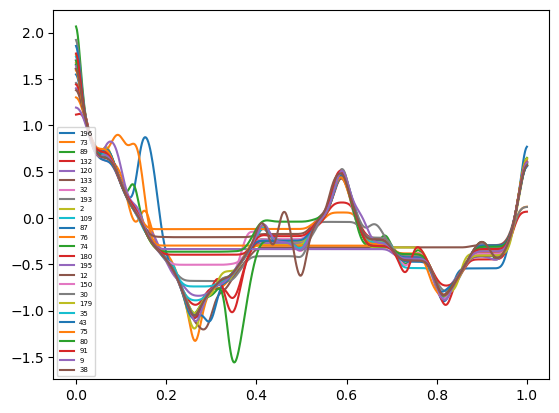

In [ ]:
for ind,data in enumerate(aligned_data_set_2):
    for index, series in enumerate(data):
                
        plt.plot(series[0,:], gaussian_filter1d(series[1,:],sigma=5) ,label=str(direction_2_original_index[ind][index]))

    plt.legend(fontsize=5)
    plt.show()


Export the signals

In [ ]:
def export_data(data,save_path='',file_name='1'):
    data_processed=[]
    for i in range(len(data)):
        series_index=pd.DataFrame([], columns=[str(i+1)])
        data_processed.append(series_index)
        if isinstance(data[0],np.ndarray):
            if data[0].ndim==1:
                data_processed.append(pd.DataFrame({'t':np.linspace(0,1,data[i].shape[1]).T,'i':data[i].T}))
            elif data[0].ndim==2:
                data_processed.append(pd.DataFrame(data[i].T,columns=['t','i']))
            else:
                print('TypeError, Please check data type')
        elif isinstance(data[0],pd.DataFrame):
            data_processed.append(data[i])
        else:
            print('TypeError, Please check data type')
            
            
    
#merge all the data 
    max_length = max([df.shape[0] for df in data_processed])

    # 填充每个 DataFrame 至最大行数
    for i, df in enumerate(data_processed):
        if df.shape[0] < max_length:
            num_missing = max_length - df.shape[0]
            missing_df = pd.DataFrame(index=range(num_missing), columns=df.columns)
            data_processed[i] = pd.concat([df, missing_df], ignore_index=True)

    # 水平拼接所有 DataFrame
    combined_df = pd.concat(data_processed, axis=1)

    # 导出为 Excel 文件
    cur_dir=os.getcwd()
    abs_save_path=os.path.join(cur_dir,save_path)
    if not os.path.exists(abs_save_path):
        os.makedirs(abs_save_path)
    combined_df.to_excel(os.path.join(abs_save_path,file_name+'.xlsx'), index=False)

In [ ]:
direction_1_export=[]
for series in barycenter_series_2:
    series_time=np.linspace(0,1,len(series))
    processed_current=gaussian_filter1d(series,sigma=3)
    direction_1_export.append(pd.DataFrame({'t':series_time,'i':processed_current}))
series_time=np.linspace(0,1,len(average_signal_2))
direction_1_export.append(pd.DataFrame({'t':series_time,'i':gaussian_filter1d(average_signal_2,sigma=3)}))
    


In [ ]:
direction_2_aligned_export=[]
for series in aligned_barycenter_2:
    series_time=np.linspace(0,1,series.shape[1])
    processed_current=gaussian_filter1d(series[1,:],sigma=3).T
    direction_2_aligned_export.append(pd.DataFrame({'t':series_time,'i':processed_current}))
series_time=np.linspace(0,1,len(average_signal_2))
direction_2_aligned_export.append(pd.DataFrame({'t':series_time,'i':gaussian_filter1d(average_signal_2,sigma=3)}))

In [ ]:
sec_path='final_export_data'
class_path='grouped_barycenter_aligned'
direction_path='direction_2'
export_data(direction_2_aligned_export,save_path=os.path.join(sec_path,class_path,direction_path),file_name='grouped_barycenter_aligned_2')